In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image
from keras_unet.utils import plot_imgs
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
# Getting The datadir to point to updated lables of data 

cwd=os.getcwd()
# print(cwd)
datadir=os.path.join(os.path.dirname(cwd),'Data','updated_masks')
print(datadir)

/home/khuzaima/Desktop/segmentation/Data/updated_masks


In [3]:
# Getting All folders in datadir
output = [dI for dI in os.listdir(datadir) if os.path.isdir(os.path.join(datadir,dI))]
print((output))

['74', '35', '69', '34', '30', '05', '61', '65', '24', '72', '44', '36', '14', '11', '33', '23', '68', '48', '57', '41', '19', '73', '32', '47', '70', '49', '25', '03', '51', '17', '64', '55', '16', '21', '56', '28', '38', '53', '50', '18', '54', '46', '06', '43', '10', '22', '60', '27', '20', '58', '67', '09', '15', '13', '12', '63', '75', '52', '26', '37', '71', '31', '62', '45', '39', '66', '02', '77', '40', '01', '76', '59', '29', '07', '04', '08', '42']


In [4]:
# Getting all images and respective masks

imgs_list = []
masks_list = []
room_masks=0
lobby_masks=0
furniture_masks=0
wall_masks=0
for folder in output:
    currentfolder=os.path.join(datadir,folder)
    onlyfiles = [f for f in os.listdir(currentfolder) if os.path.isfile(os.path.join(currentfolder, f))]
    flagroom=False
    flaglobby=False
    flagwall=False
    flagfurniture=False
    for file in onlyfiles:
        if 'real' in file:
            currentfile=os.path.join(currentfolder, file)
            image=np.array(Image.open(currentfile).convert('RGB').resize((384,384)))
            imgs_list.append(image)
        if 'room' in file:
            currentfile=os.path.join(currentfolder, file)
            room=np.array(Image.open(currentfile).resize((384,384)))
            room = room[:, :, 3]
            flagroom=True
        if 'lobby' in file:
            currentfile=os.path.join(currentfolder, file)
            lobby=np.array(Image.open(currentfile).resize((384,384)))
            lobby = lobby[:, :, 3]
            flaglobby=True
        if 'wall' in file:
            currentfile=os.path.join(currentfolder, file)
            wall=np.array(Image.open(currentfile).resize((384,384)))
            wall = wall[:, :, 3]
            flagwall=True
        if 'furniture' in file:
            currentfile=os.path.join(currentfolder, file)
            furniture=np.array(Image.open(currentfile).resize((384,384)))
            furniture = furniture[:, :, 3]
            flagfurniture=True
    mask=np.zeros((384,384,4))
    mask[:,:,0]=image[:,:,0]
    #print(mask.shape)
    if flagroom:
        mask[:,:,0]=room
        room_masks+=1
    else:
        mask[:,:,0]=0
    if flagwall:
        mask[:,:,1]=wall
        wall_masks+=1
    else:
        mask[:,:,1]=0
    if flaglobby:
        mask[:,:,2]=lobby
        lobby_masks+=1
    else:
        mask[:,:,2]=0
    if flagfurniture:
        mask[:,:,3]=furniture
        furniture_masks+=1
    else:
        mask[:,:,3]=0
    masks_list.append(mask)
imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

print("Room Masks :",room_masks)
print("Wall Masks :",wall_masks)
print("Lobby Masks :",lobby_masks)
print("Furniture Masks :",furniture_masks)

Room Masks : 50
Wall Masks : 77
Lobby Masks : 77
Furniture Masks : 4


In [5]:
print(imgs_np.shape,masks_np.shape)

(77, 384, 384, 3) (77, 384, 384, 4)


In [6]:
# Seperaing different masks for better visualization

masks_room=masks_np[:,:,:,0]
masks_wall=masks_np[:,:,:,1]
masks_lobby=masks_np[:,:,:,2]
masks_furniture=masks_np[:,:,:,3]
masks_room=np.expand_dims(masks_room, axis=3)
masks_wall=np.expand_dims(masks_wall, axis=3)
masks_lobby=np.expand_dims(masks_lobby, axis=3)
masks_furniture=np.expand_dims(masks_furniture, axis=3)

In [7]:
print(imgs_np.shape,masks_room.shape,masks_wall.shape,masks_lobby.shape,masks_furniture.shape)

(77, 384, 384, 3) (77, 384, 384, 1) (77, 384, 384, 1) (77, 384, 384, 1) (77, 384, 384, 1)


In [ ]:
# Visualize masks
plot_imgs(org_imgs=imgs_np, mask_imgs=masks_wall, nm_img_to_plot=5, figsize=6)

# Complete Model

In [8]:
print(imgs_np.max(), masks_np.max())

255 255.0


In [9]:
# Normalizing all pixels of Images and masks to have values between 0 and 1
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

In [10]:
print(x.min(),x.max(),y.min(), y.max())

0.0 1.0 0.0 1.0


In [11]:
# Splitting data into training and validation with 0.1 split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)


x_train:  (69, 384, 384, 3)
y_train:  (69, 384, 384, 4)
x_val:  (8, 384, 384, 3)
y_val:  (8, 384, 384, 4)


In [12]:
# Augmenting training data
train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [13]:
# Check sample of train data generator
sample_batch = next(train_gen)
xx, yy = sample_batch
masks_room_augmented=yy[:,:,:,0]
masks_wall_augmented=yy[:,:,:,1]
masks_lobby_augmented=yy[:,:,:,2]
masks_furniture_augmented=yy[:,:,:,3]
masks_room_augmented=np.expand_dims(masks_room_augmented, axis=3)
masks_wall_augmented=np.expand_dims(masks_wall_augmented, axis=3)
masks_lobby_augmented=np.expand_dims(masks_lobby_augmented, axis=3)
masks_furniture_augmented=np.expand_dims(masks_furniture_augmented, axis=3)

print(xx.shape,masks_room_augmented.shape,masks_wall_augmented.shape,masks_lobby_augmented.shape,masks_furniture_augmented.shape)

(8, 384, 384, 3) (8, 384, 384, 1) (8, 384, 384, 1) (8, 384, 384, 1) (8, 384, 384, 1)


In [ ]:
# Plot sample of augmented images and masks
plot_imgs(org_imgs=xx, mask_imgs=masks_room_augmented, nm_img_to_plot=8, figsize=6)

In [15]:
# Model Definition
input_shape = x[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_classes=4,
    num_layers=2
)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 384, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 384, 384, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
# Define Model Checkpoint
model_filename = 'segm_model_complete_data.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [18]:
# Compile Model
model.compile(
    optimizer=Adam(), 
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou]
)

In [19]:
# Below Line is needed if tf Version is 2.0.0
train_gen = (pair for pair in train_gen)

In [20]:
#Train Model
history = model.fit_generator(
    train_gen,
    validation_data=(x_val, y_val),
    steps_per_epoch=50,
    epochs=10,
    callbacks=[callback_checkpoint]
)

Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.6357 - iou: 0.1787
Epoch 00001: val_loss improved from inf to 1.32519, saving model to segm_model_complete_data.h5
50/50 [==============================] - 28s 564ms/step - loss: 0.6341 - iou: 0.1789 - val_loss: 1.3252 - val_iou: 0.1621
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 0.5242 - iou: 0.2014
Epoch 00002: val_loss improved from 1.32519 to 0.64560, saving model to segm_model_complete_data.h5
50/50 [==============================] - 24s 472ms/step - loss: 0.5229 - iou: 0.2012 - val_loss: 0.6456 - val_iou: 0.1881
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 0.4237 - iou: 0.2236
Epoch 00003: val_loss improved from 0.64560 to 0.49486, saving model to segm_model_complete_data.h5
50/50 [==============================] - 24s 471ms/step - loss: 0.4224 - iou: 0.2245 - val_loss: 0.4949 - val_iou: 0.2058
Epoch 4/10
49/50 [============================>.] - ETA: 0s - loss: 0.3

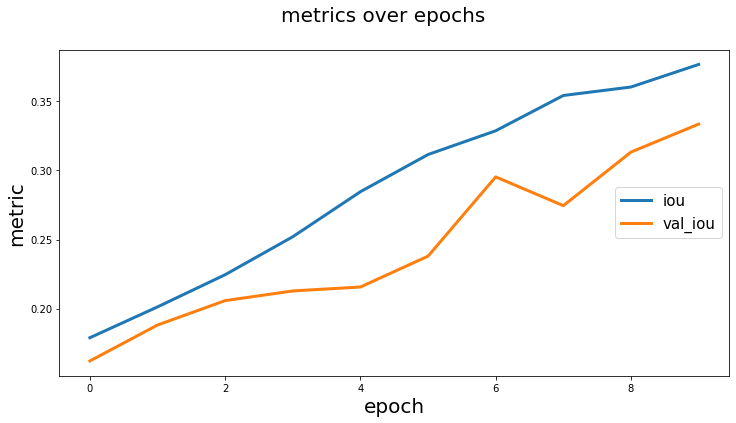

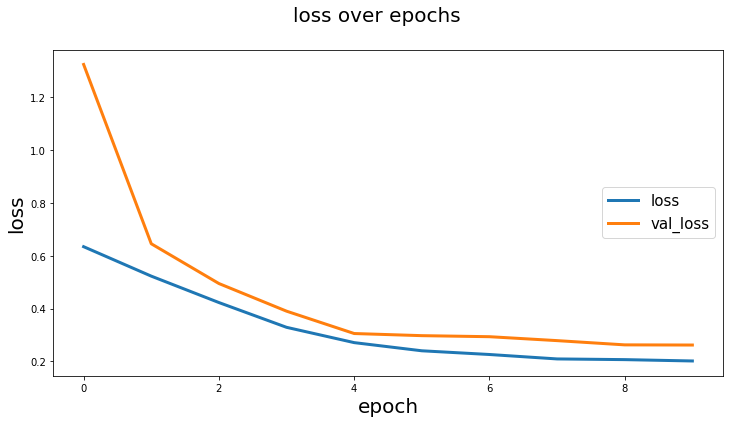

In [21]:
# Plot Segmentation History
plot_segm_history(history)

In [22]:
# Load Model Weights and predict on validation dataset
model.load_weights(model_filename)
y_pred = model.predict(x_val)

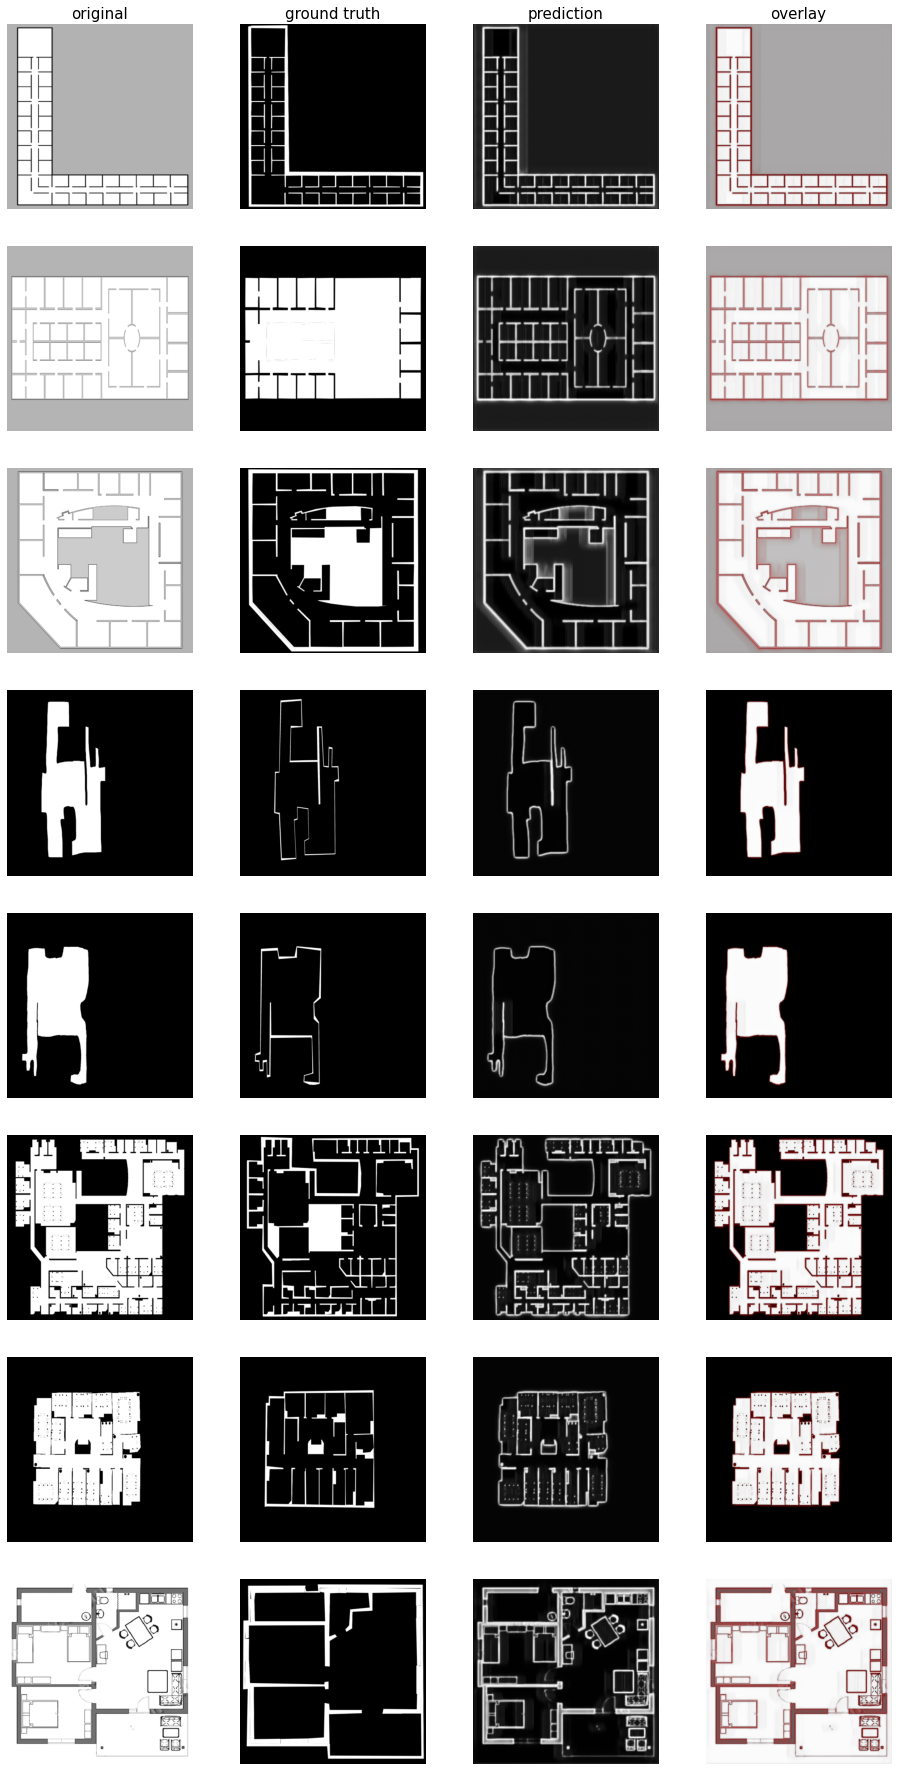

In [25]:
# Visualize Predictions  ( y_val[:,:,:,0] AND pred_imgs=y_pred[:,:,:,0] for first class and So on )
plot_imgs(org_imgs=x_val, mask_imgs=y_val[:,:,:,1], pred_imgs=y_pred[:,:,:,1], nm_img_to_plot=8)

# Only Room Masks Model

In [26]:
# Normalize images and masks. Split Data into training and validation set
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_room, dtype=np.float32)/255
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (69, 384, 384, 3)
y_train:  (69, 384, 384, 1)
x_val:  (8, 384, 384, 3)
y_val:  (8, 384, 384, 1)


In [27]:
# Augment Data
train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [29]:
# Model Definition
input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=2
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 384, 384, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 384, 384, 32) 128         conv2d_11[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_3 (SpatialDro (None, 384, 384, 32) 0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

In [30]:
# Define Model Checkpoint
model_filename = 'segm_model_room_data.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)



In [31]:
# Compile Model
model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou]
)

In [32]:
# Below Line is needed if tf Version is 2.0.0
train_gen = (pair for pair in train_gen)

In [33]:
#Train model
history = model.fit(
    train_gen,
    validation_data=(x_val, y_val),
    steps_per_epoch=50,
    epochs=10,
    callbacks=[callback_checkpoint]
)

Train for 50 steps, validate on 8 samples
Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.5931 - iou: 0.2505
Epoch 00001: val_loss improved from inf to 5.97564, saving model to segm_model_room_data.h5
50/50 [==============================] - 25s 509ms/step - loss: 0.5909 - iou: 0.2507 - val_loss: 5.9756 - val_iou: 0.3188
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 0.4683 - iou: 0.2741
Epoch 00002: val_loss improved from 5.97564 to 2.58454, saving model to segm_model_room_data.h5
50/50 [==============================] - 24s 475ms/step - loss: 0.4673 - iou: 0.2739 - val_loss: 2.5845 - val_iou: 0.3648
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 0.3915 - iou: 0.3029
Epoch 00003: val_loss improved from 2.58454 to 0.45461, saving model to segm_model_room_data.h5
50/50 [==============================] - 23s 461ms/step - loss: 0.3904 - iou: 0.3035 - val_loss: 0.4546 - val_iou: 0.2201
Epoch 4/10
49/50 [=======================

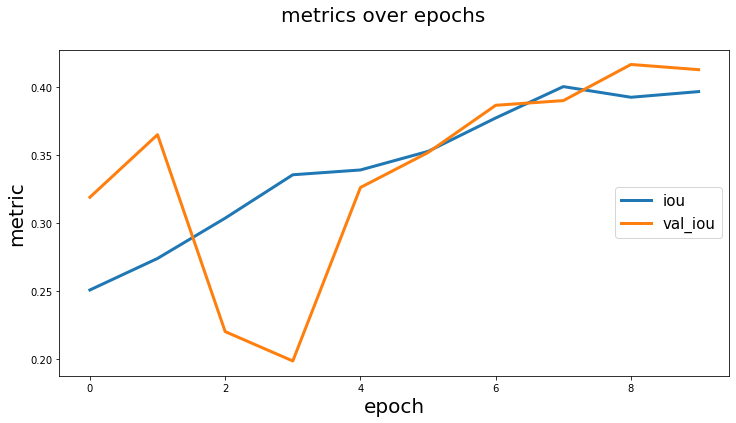

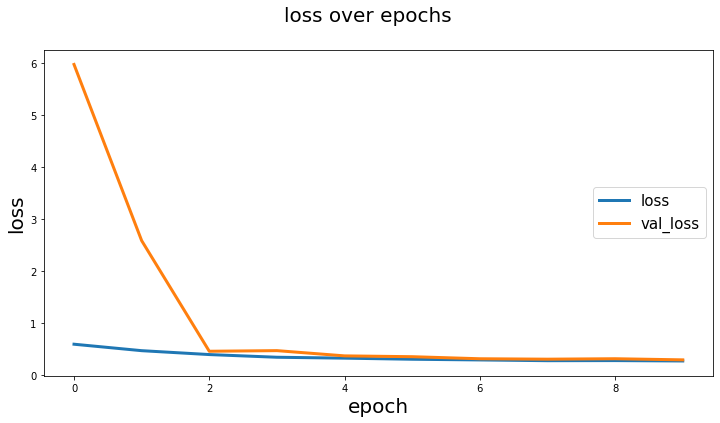

In [34]:
# Plot Training History
plot_segm_history(history)

In [35]:
# Predict on validation set
model.load_weights(model_filename)
y_pred = model.predict(x_val)

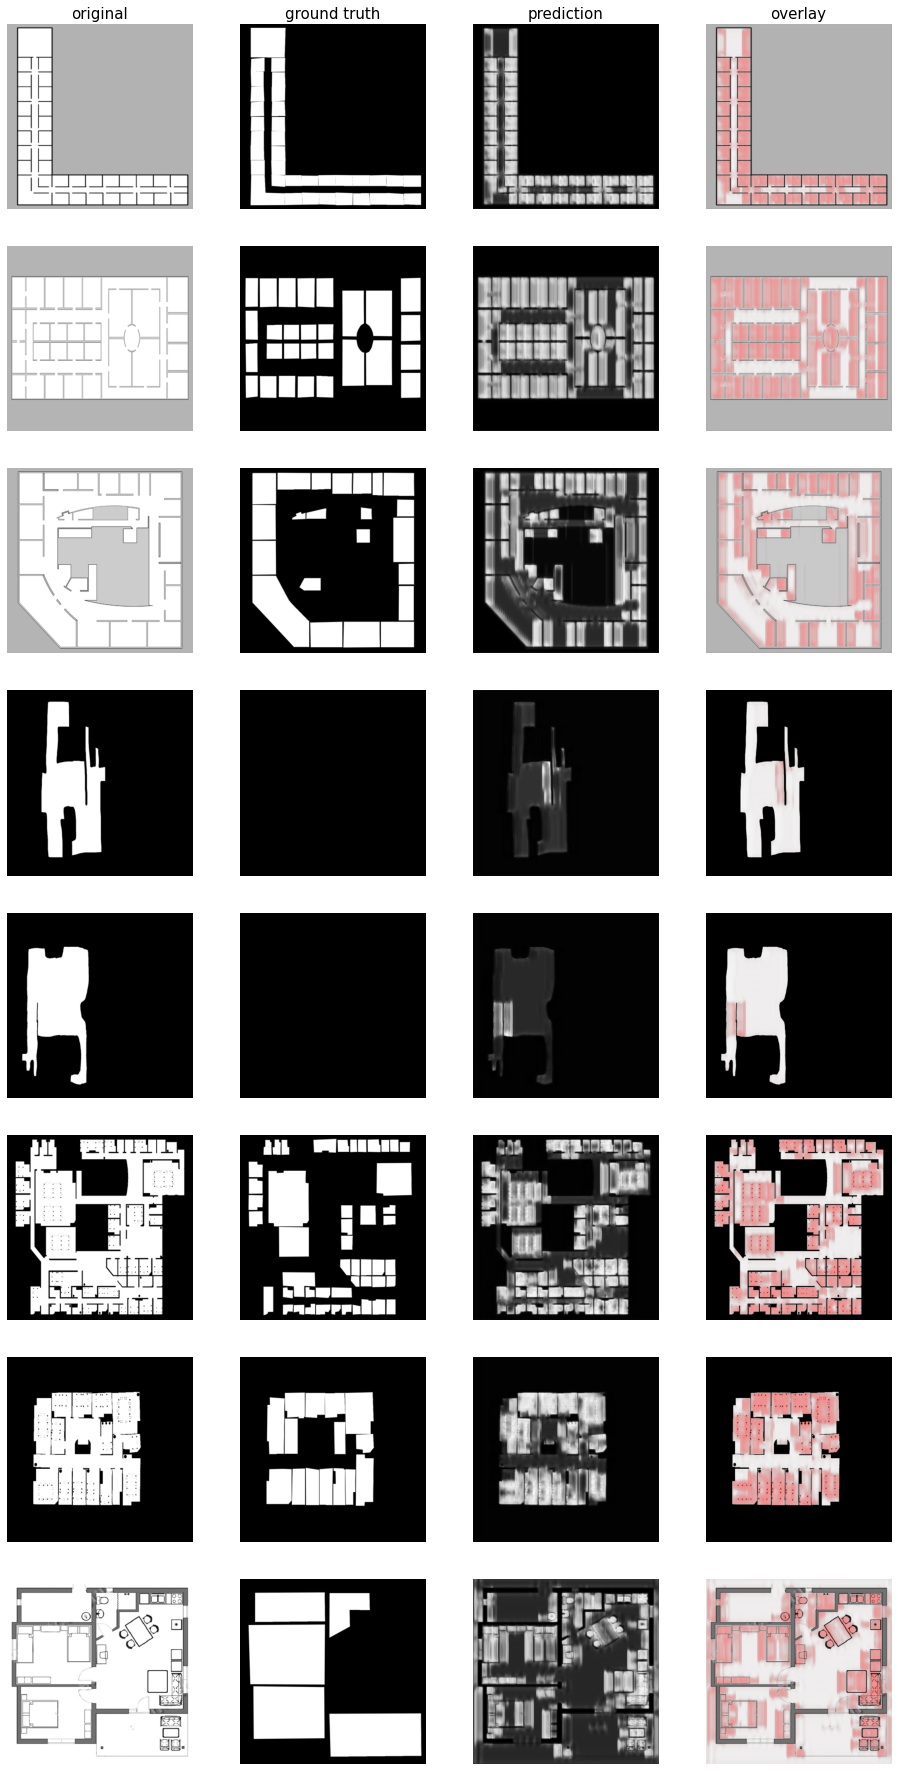

In [36]:
# Visualize Predictions  ( y_val[:,:,:,0] AND pred_imgs=y_pred[:,:,:,0] for first class and So on )
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=8)

# Only Lobby Masks Model

In [37]:
# Normalize images and masks. Split Data into training and validation set
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_lobby, dtype=np.float32)/255
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)



x_train:  (69, 384, 384, 3)
y_train:  (69, 384, 384, 1)
x_val:  (8, 384, 384, 3)
y_val:  (8, 384, 384, 1)


In [38]:
# Augment Data
train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [39]:
# Model Definition
input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=2
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 384, 384, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 384, 384, 32) 128         conv2d_22[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_6 (SpatialDro (None, 384, 384, 32) 0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [40]:
# Define Model Checkpoint
model_filename = 'segm_model_lobby_data.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)



In [41]:
# Compile model
model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou]
)

In [42]:
# Below Line is needed if tf Version is 2.0.0
train_gen = (pair for pair in train_gen)

In [43]:
# Train Model
history = model.fit(
    train_gen,
    validation_data=(x_val, y_val),
    steps_per_epoch=50,
    epochs=10,
    callbacks=[callback_checkpoint]
)

Train for 50 steps, validate on 8 samples
Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.5608 - iou: 0.3181
Epoch 00001: val_loss improved from inf to 1.07670, saving model to segm_model_lobby_data.h5
50/50 [==============================] - 25s 495ms/step - loss: 0.5586 - iou: 0.3187 - val_loss: 1.0767 - val_iou: 0.0539
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 0.4393 - iou: 0.3525
Epoch 00002: val_loss improved from 1.07670 to 0.70243, saving model to segm_model_lobby_data.h5
50/50 [==============================] - 23s 463ms/step - loss: 0.4370 - iou: 0.3543 - val_loss: 0.7024 - val_iou: 0.0326
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 0.3819 - iou: 0.3602
Epoch 00003: val_loss improved from 0.70243 to 0.45532, saving model to segm_model_lobby_data.h5
50/50 [==============================] - 24s 473ms/step - loss: 0.3811 - iou: 0.3601 - val_loss: 0.4553 - val_iou: 0.2400
Epoch 4/10
49/50 [====================

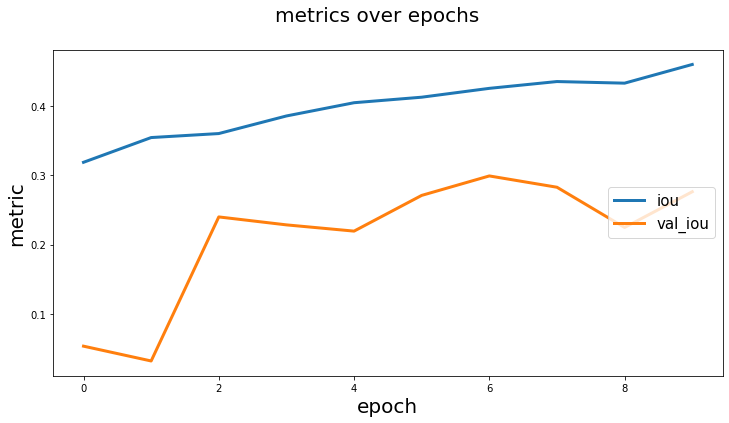

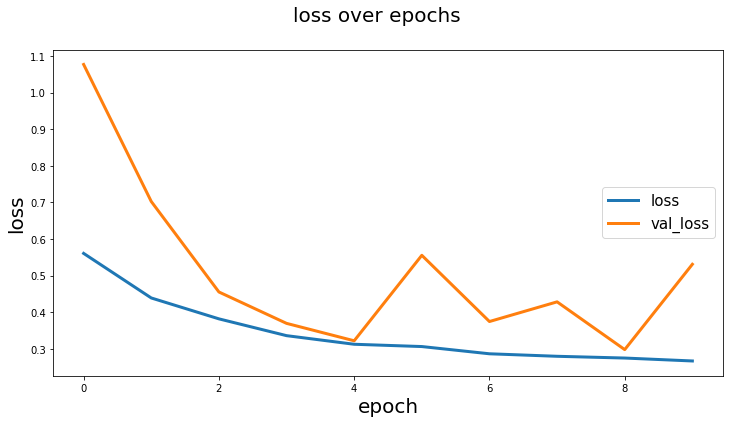

In [44]:
# Plot Training History
plot_segm_history(history)

In [45]:
# Load Model Weights and predict on validation set
model.load_weights(model_filename)
y_pred = model.predict(x_val)

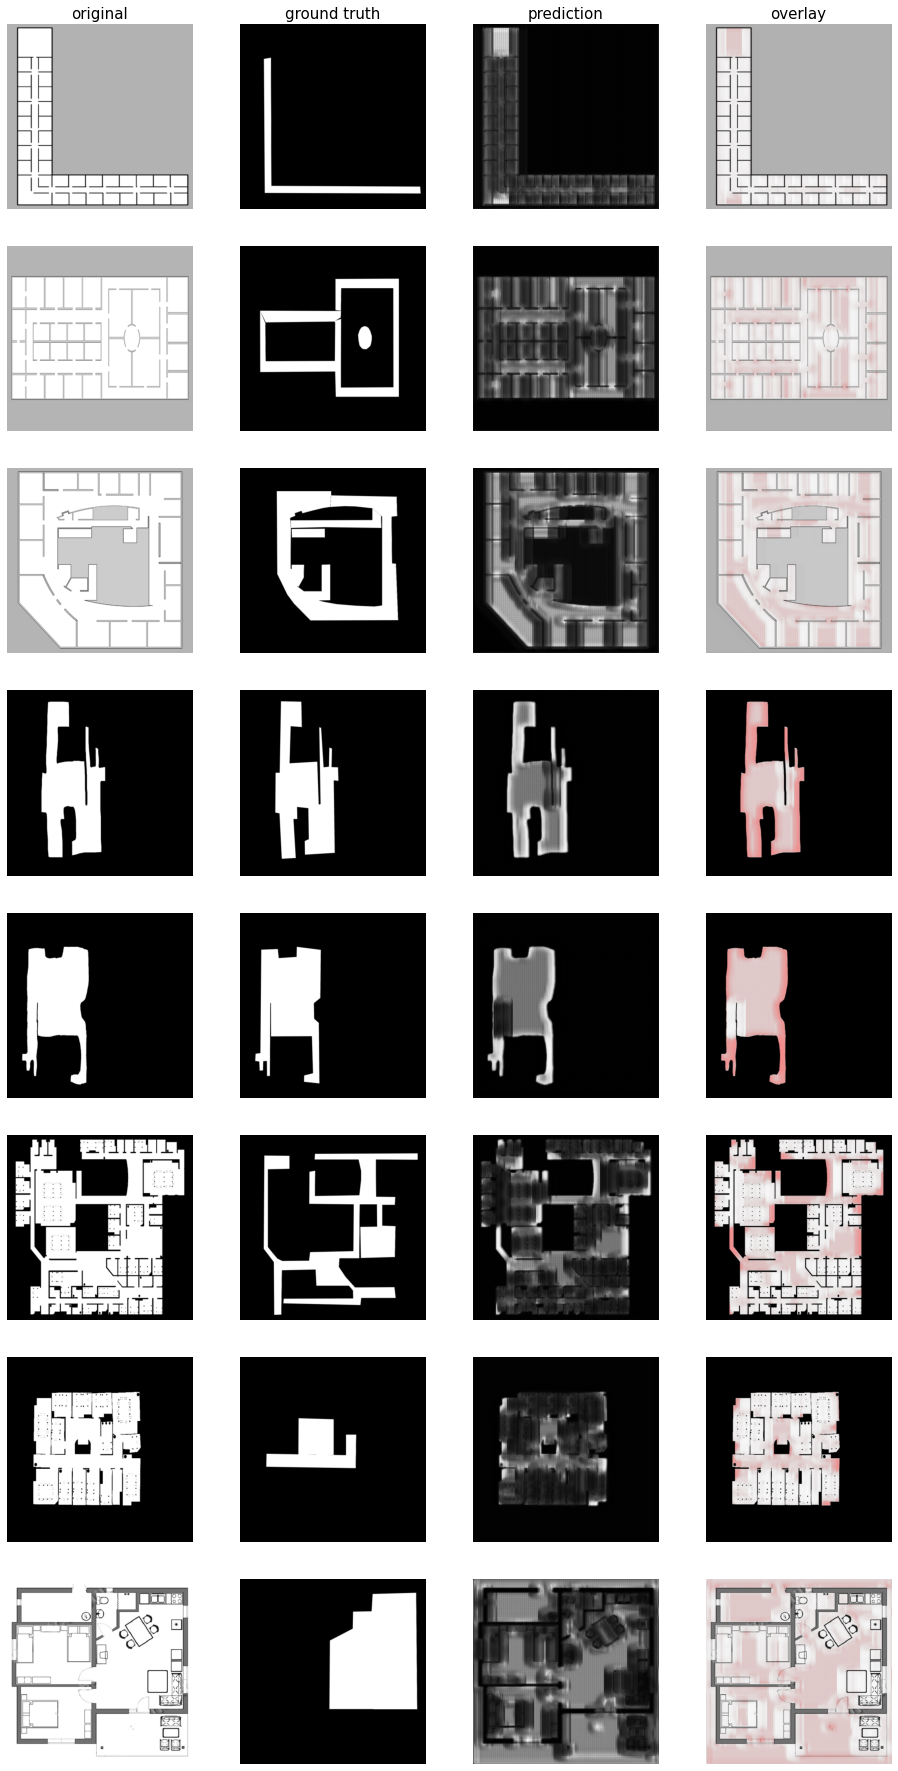

In [46]:
# Plot Predictions
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)

# Only Walls Masks Model

In [47]:
# Normalize images and masks. Split Data into training and validation set
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_wall, dtype=np.float32)/255
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)



x_train:  (69, 384, 384, 3)
y_train:  (69, 384, 384, 1)
x_val:  (8, 384, 384, 3)
y_val:  (8, 384, 384, 1)


In [48]:
# Augment Data
train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [49]:
# Define Model
input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=2
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 384, 384, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 384, 384, 32) 128         conv2d_33[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 384, 384, 32) 0           batch_normalization_30[0][0]     
____________________________________________________________________________________________

In [50]:
# Define Model Checkpoint
model_filename = 'segm_model_v3_wall.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)



In [51]:
# Compile Model
model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou]
)

In [53]:
# Below Line is needed if tf Version is 2.0.0
train_gen = (pair for pair in train_gen)

In [54]:
# Train Model
history = model.fit(
    train_gen,
    validation_data=(x_val, y_val),
    steps_per_epoch=50,
    epochs=10,
    callbacks=[callback_checkpoint]
)

Train for 50 steps, validate on 8 samples
Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.6185 - iou: 0.1400
Epoch 00001: val_loss improved from inf to 0.52821, saving model to segm_model_v3_wall.h5
50/50 [==============================] - 26s 523ms/step - loss: 0.6163 - iou: 0.1399 - val_loss: 0.5282 - val_iou: 0.1194
Epoch 2/10
49/50 [============================>.] - ETA: 0s - loss: 0.4701 - iou: 0.1518
Epoch 00002: val_loss improved from 0.52821 to 0.46546, saving model to segm_model_v3_wall.h5
50/50 [==============================] - 23s 469ms/step - loss: 0.4685 - iou: 0.1521 - val_loss: 0.4655 - val_iou: 0.1578
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 0.3769 - iou: 0.1629
Epoch 00003: val_loss improved from 0.46546 to 0.42590, saving model to segm_model_v3_wall.h5
50/50 [==============================] - 24s 481ms/step - loss: 0.3748 - iou: 0.1627 - val_loss: 0.4259 - val_iou: 0.1614
Epoch 4/10
49/50 [============================>

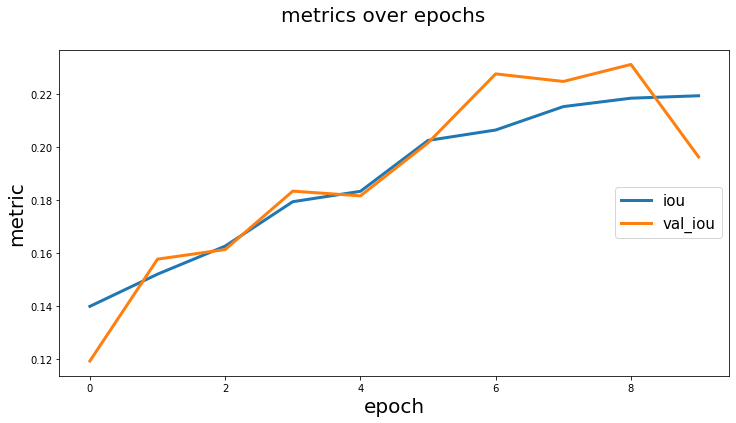

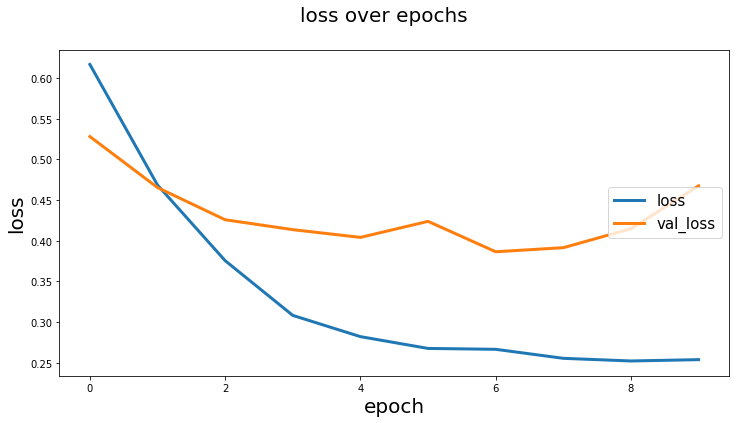

In [55]:
# Plot training history
plot_segm_history(history)

In [56]:
#Prediction
model.load_weights(model_filename)
y_pred = model.predict(x_val)

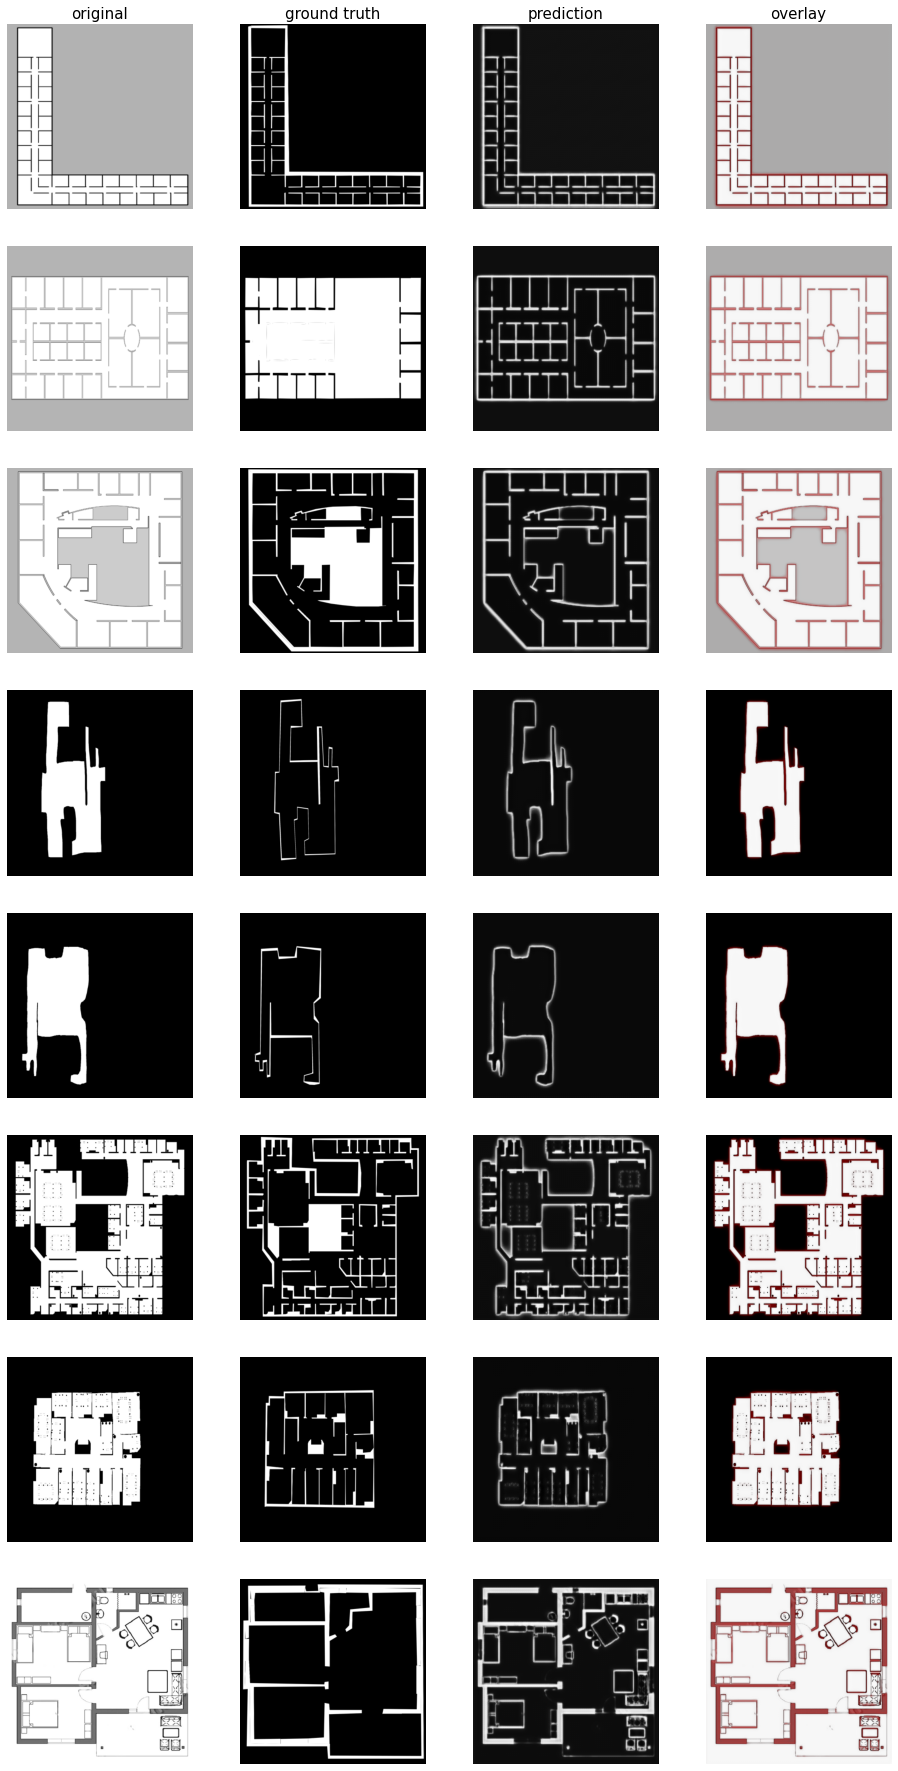

In [57]:
# Visualize Prediction
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)